In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/mnt/c/Users/mtr22/code/mre-pinn/notebooks'

In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /mnt/c/Users/mtr22/code/mre-pinn/notebooks/../mre_pinn/__init__.py


In [3]:
# load the MATLAB file
data_root = '../data/BIOQIC'
mat_base = 'four_target_phantom.mat'

mat_file = data_root + '/' + mat_base
data, rev_axes = mre_pinn.data.load_mat_data(mat_file, verbose=True)
rev_axes

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128


True

In [4]:
# convert to xarray and add metadata
u_true = data['u_ft'].T
u_dims = ['frequency', 'component', 'z', 'x', 'y']
u_coords = {
    'frequency': 50 + np.arange(u_true.shape[0]) * 10, # Hz
    'x': np.arange(u_true.shape[3]) * 1e-3, # m
    'y': np.arange(u_true.shape[4]) * 1e-3, # m
    'z': np.arange(u_true.shape[2]) * 1e-3, # m
    'component': ['y', 'x', 'z'],
}
u_true = xr.DataArray(u_true, dims=u_dims, coords=u_coords)
u_true = u_true.transpose('frequency', 'x', 'y', 'z', 'component')

# downsampling
ds = 1
u_true = u_true.coarsen(x=ds, y=ds, z=ds).mean()

# single frequency 2D
u_true = u_true.sel(frequency=[60], z=0, component=['x', 'y'])

# single frequency 3D
#u_true = u_true.sel(frequency=[60], component=['x', 'y', 'z'])

# multifrequency 3D
#u_true = u_true.sel(component=['x', 'y', 'z'])

print(np.prod(u_true.shape))
u_true

16000


<xarray.DataArray (frequency: 1, x: 80, y: 100, component: 2)>
array([[[[-3.54987721e-12+4.70068174e-12j,
          -1.40539547e-04-1.26790721e-04j],
         [-2.86696146e-12+3.08723745e-12j,
          -2.01890519e-04-3.98395504e-06j],
         [ 0.00000000e+00+0.00000000e+00j,
          -2.38881797e-04+9.20685788e-05j],
         ...,
         [ 0.00000000e+00+0.00000000e+00j,
           1.27499474e-03-3.83990886e-04j],
         [ 7.54510765e-14-8.00958312e-13j,
           1.26002577e-03-3.73149316e-04j],
         [ 0.00000000e+00+0.00000000e+00j,
           1.22505327e-03-3.52941489e-04j]],

        [[ 8.96827099e-05-1.13514917e-04j,
          -1.32552255e-04-1.45164631e-04j],
         [ 7.53837347e-05-8.13587914e-05j,
          -1.90706286e-04-2.59523219e-05j],
         [ 6.56188315e-05-5.50277872e-05j,
          -2.28230418e-04+7.04478221e-05j],
...
         [-1.10374529e-04-9.23145828e-04j,
          -8.14959727e-05+1.39799530e-03j],
         [-1.09997556e-04-9.09463356e-04j,
          -1.36961202e-05+1.23880399e-03j],
         [-1.23367892e-04-9.26021688e-04j,
           2.98841303e-05+1.06783136e-03j]],

        [[-8.12646285e-04-7.09290650e-04j,
          -1.92143971e-04-8.69458900e-04j],
         [-8.03706863e-04-6.00373045e-04j,
          -1.79776557e-04-1.05543393e-03j],
         [-8.10801955e-04-5.26895868e-04j,
          -1.42013706e-04-1.24291501e-03j],
         ...,
         [-3.00958597e-05-9.45729850e-04j,
          -1.42522864e-04+1.55291758e-03j],
         [-4.50838009e-05-9.46362084e-04j,
          -3.75395832e-05+1.38343851e-03j],
         [-7.30770324e-05-9.77355167e-04j,
           2.17137599e-05+1.21215436e-03j]]]])
Coordinates:
  * frequency  (frequency) int64 60
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'x' 'y'

<IPython.core.display.Javascript object>


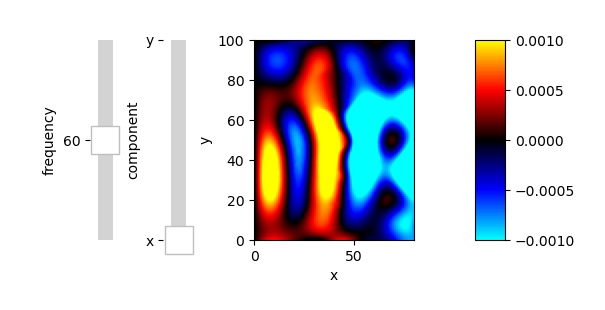

In [8]:
# display wave field
w_map = mre_pinn.visual.wave_color_map()
w_max = 0.001
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

mre_pinn.visual.NDArrayViewer(u_true.real, dpi=50/ds, **wave_kws)

In [123]:
%autoreload

batch_size = 128 # collocation points
num_domain = 128 # PDE domain samples

# convert to point set boundary condition
bc = mre_pinn.data.NDArrayBC(u_true, batch_size=batch_size)
x = bc.points
x.shape, bc.values.shape, x.shape[0] / batch_size

((8000, 3), torch.Size([8000, 2]), 62.5)

In [124]:
# for single frequency, we need to add eps to the geometry range to avoid zero volume
eps = np.array([1e-5] + [0] * (x.shape[1] - 1))
x.max(axis=0) - x.min(axis=0) + eps

array([1.00000000e-05, 7.90000036e-02, 9.89999995e-02])

In [125]:
%autoreload

# set up PDE with geometry and boundary condition
residual = mre_pinn.pde.HelmholtzPDE(detach=False)
geometry = deepxde.geometry.Hypercube(x.min(axis=0) - eps/2, x.max(axis=0) + eps/2)
pde = deepxde.data.PDE(geometry, residual, bc, num_domain=num_domain)
pde.train_x.shape

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+130=130. 
  warnings.warn("The balance properties of Sobol' points require "


(256, 3)

In [126]:
%autoreload

# initialize neural network
parallel = False
if parallel:
    net = mre_pinn.model.Parallel([
        mre_pinn.model.PINN(
            n_input=x.shape[1],
            n_layers=5,
            n_hidden=64,
            n_output=n_output,
            activ_fn=torch.sin,
            complex=True,
            dense=True,
            transform=False,
            omega0=8
        ) for n_output in [u_true.shape[-1], 1] # u and mu
    ])
else:
    net = mre_pinn.model.PINN(
        n_input=x.shape[1],
        n_layers=5,
        n_hidden=128,
        n_output=u_true.shape[-1] + 1, # u an dmu
        activ_fn=torch.sin,
        complex=True,
        dense=True,
        transform=False,
        omega0=32
    )

# standardize inputs to [-1, 1]
x = bc.points
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

if x_scale[0] == 0: # single frequency check
    x_scale[0] = 1

# normalize outputs
u = bc.values.cpu().numpy()
u = np.concatenate([u.real, u.imag], axis=1)
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)
print(u_scale.shape)

mu_loc = [5, 5]
mu_scale = [5, 5]

# initialize model weights
if parallel:
    net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=u_loc, output_scale=u_scale)
    net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=mu_loc, output_scale=mu_scale)
else:
    output_loc = np.append(u_loc, mu_loc)
    output_scale = np.append(u_scale, mu_scale)
    net.init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=output_loc, output_scale=output_scale)

net

(4,)


PINN(
  (linear0): Linear(in_features=3, out_features=128, bias=True)
  (linear1): Linear(in_features=131, out_features=128, bias=True)
  (linear2): Linear(in_features=259, out_features=128, bias=True)
  (linear3): Linear(in_features=387, out_features=128, bias=True)
  (linear4): Linear(in_features=515, out_features=6, bias=True)
)

In [127]:
%autoreload

def msae_loss(y_true, y_pred):
    '''
    Mean squared absolute error.
    '''
    error = y_true - y_pred
    return torch.mean(torch.abs(error)**2)

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss=msae_loss,
    loss_weights=[1e-10, 100]
)

Compiling model...
'compile' took 0.000140 s



Training model...



<IPython.core.display.Javascript object>


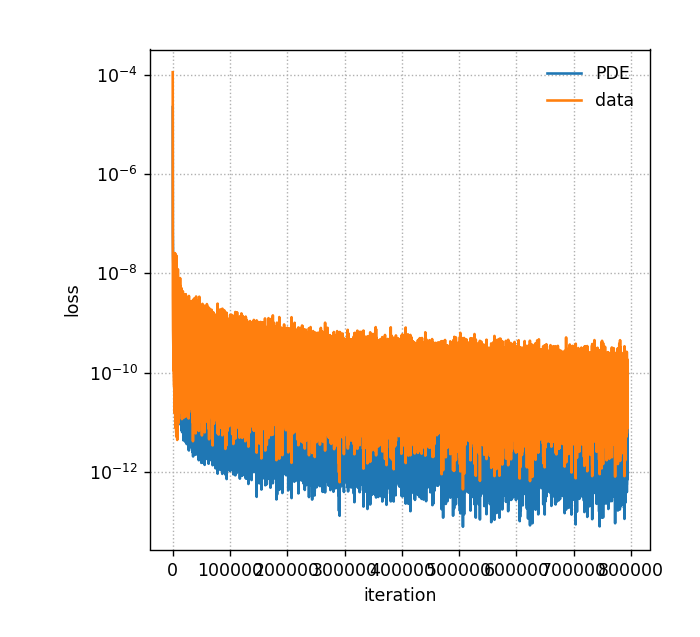

Interrupt


In [128]:
deepxde.display.training_display = mre_pinn.visual.TrainingPlot()
try:
    model.train(1000000, display_every=10)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [138]:
model.train_state.loss_train

array([7.75794347e-13, 1.00523031e-11])

In [139]:
# model predictions
x = bc.points
outputs = model.predict(x)
u_pred  = outputs[:,:-1].reshape(u_true.shape)
mu_pred = outputs[:,-1:].reshape(u_true.shape[:-1])
lu_pred = model.predict(
    x, operator=lambda x, y: mre_pinn.pde.laplacian(y[:,:-1], x, dim=1)
).reshape(u_true.shape)

<IPython.core.display.Javascript object>


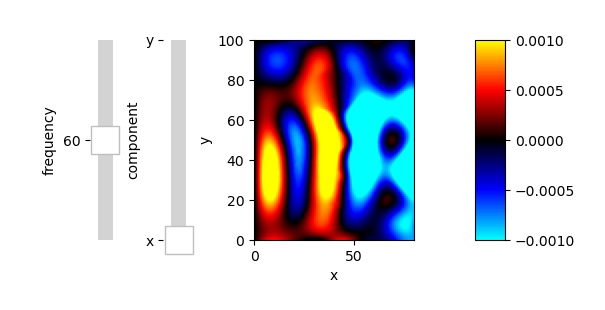

<IPython.core.display.Javascript object>


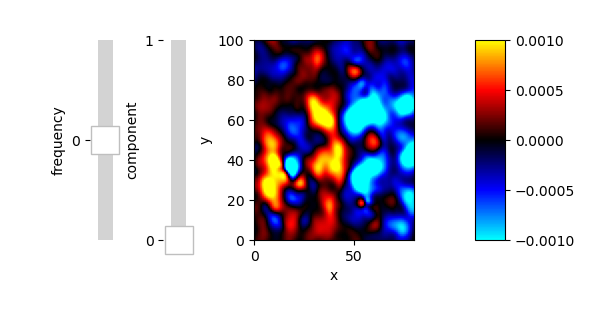

In [140]:
%autoreload

# display wave field
w_map = mre_pinn.visual.wave_color_map()
w_max = 0.001
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

mre_pinn.visual.NDArrayViewer(u_true.real, labels=u_true.dims, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred.real, labels=u_true.dims, dpi=50/ds, **wave_kws)

<IPython.core.display.Javascript object>


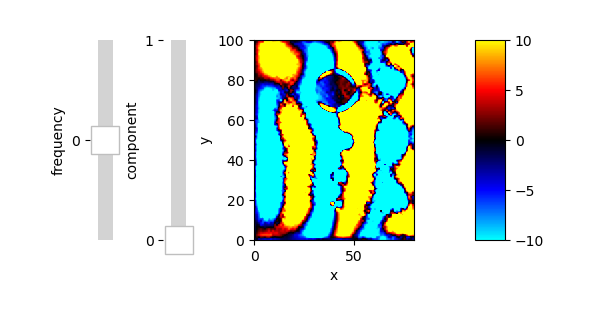

<IPython.core.display.Javascript object>


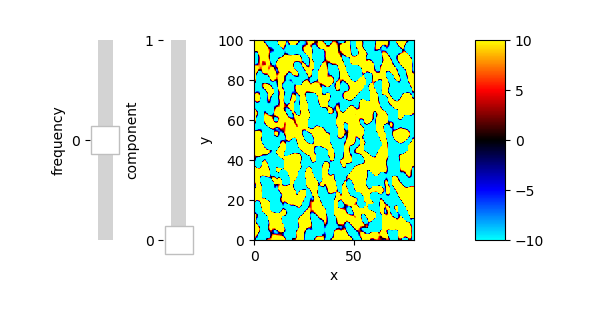

In [134]:
# compute discrete laplacian of wave field

def discrete_laplacian(u, resolution=1, dim=0):
    '''
    Discrete Laplacian operator.
    '''
    components = []
    grad = np.gradient
    for i in range(u.shape[-1]):
        component = 0
        for j in range(dim, len(u.shape) - 1):
            component += grad(grad(u[...,i], axis=j), axis=j) / resolution**2
        components.append(component)
    return np.stack(components, axis=-1)

dx = 1e-3
Lu_true = discrete_laplacian(u_true, resolution=dx, dim=1)
Lu_pred = discrete_laplacian(u_pred, resolution=dx, dim=1)

# display wave field laplacians
L_max = 10 #1e3
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

mre_pinn.visual.NDArrayViewer(Lu_true.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(Lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)

<IPython.core.display.Javascript object>


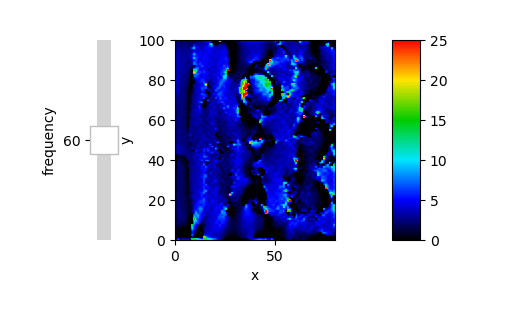

/mnt/c/Users/mtr22/code/mre-pinn/notebooks/../mre_pinn/visual.py:322: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  slider = matplotlib.widgets.Slider(


<IPython.core.display.Javascript object>


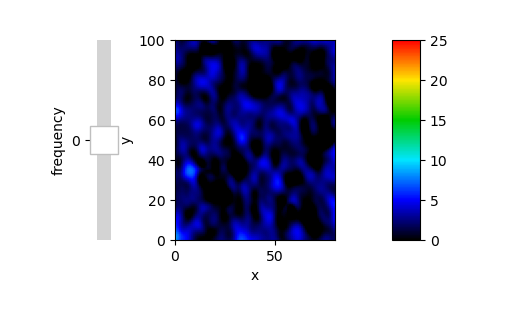

In [135]:
from scipy.ndimage import gaussian_filter

# compare elastograms

def direct_inversion(u, Lu, omega, rho=1):
    return (-rho * (2*np.pi*omega)**2 * u / Lu).mean(axis=-1)

omega = float(u_true.frequency)
mu_data = direct_inversion(u_true, Lu_true, omega)
mu_u_Lu = direct_inversion(u_pred, Lu_pred, omega)
mu_u_lu = direct_inversion(u_pred, lu_pred, omega)

# display elastogram
e_map = mre_pinn.visual.elast_color_map()
e_max = 25
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

mre_pinn.visual.NDArrayViewer(mu_data.real, labels=u_true.dims[:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_Lu.real, labels=u_true.dims[:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_lu.real, labels=u_true.dims[:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_pred.real, labels=u_true.dims[:-1], dpi=50/ds, **elast_kws)